# TrailNet Prediction
1. Import libraries
2. Get ready for pre-trained model
3. Load testing dataset
4. Perform prediction and save result 

## 1. Import libraries

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
from shutil import rmtree
from zipfile import ZipFile
import gdown
import sys
import os
import cv2

caffe_root = os.environ['CAFFE_ROOT']
project_root = os.getcwd()

import caffe

In [2]:
# display plots in this notebook
%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

## 2. Get ready for pre-trained model

In [3]:
prototxt_url = 'https://drive.google.com/uc?id=1-kT2Vnr_TgUcQa7cz6acXW7n5GWRtFyF'
prototxt_name = 'trailnet_color_o3.prototxt'

caffemodel_url = 'https://drive.google.com/uc?id=1fWCQ5ZsY_KziwqGWeLJuUl6IlAh98dSi'
caffemodel_name = 'trailnet_3class_real_vr_mix_color.caffemodel'

if not os.path.isfile(caffemodel_name):
    print('Downloading pre-trained TrailNet model...')
    gdown.download(caffemodel_url, output=caffemodel_name, quiet=False)
if not os.path.isfile(prototxt_name):
    print('Downloading pre-trained TrailNet prototxt...')
    gdown.download(prototxt_url, output=prototxt_name, quiet=False)

print('Finished preparing the model.')             

Finished preparing the model.


## 3. Load testing dataset

In [4]:
testdata_url = 'https://drive.google.com/uc?id=1cKLNz86fd-20I-lMELVf2lUUvUbFGx-u'
testdata_name = 'YB_3class_60'

classid_url = 'https://drive.google.com/uc?id=1QrUIUSQSCSagcMgV_1RnQjQKqRhuaBFf'
classid_name = 'class_id.txt'

if not os.path.isdir('data'):
    os.mkdir('data')
    call(['chmod', '-R', '666', 'data'])
    
if not os.path.isfile(classid_name):
    gdown.download(classid_url, output=classid_name, quiet=False)
    
if not os.path.isfile(testdata_name + '.zip'):
    print('Downloading testing dataset...')
    gdown.download(testdata_url, output=testdata_name+'.zip', quiet=False)
    print('Unzip testing dataset...')
    zip = ZipFile(testdata_name+'.zip')
    zip.extractall('data')
    zip.close()

print('Finished preparing the testing dataset.')       

Finished preparing the testing dataset.


### 3-1. Function of  image loader

In [5]:
class Lexicon:
    def __init__(self):
        self.path = ''
        
    def set_image_lex(self,lex):
        self.image_lex = lex
        
    def set_image_gt(self,gt):
        self.gt = gt
        
    def set_image_number(self,number):
        self.image_number = number
    
    def set_image_path(self,path):
        self.image_path = path

In [6]:
def load_images_from_folder(folder, class_type, lex):
    data_list = []
    folder_path = folder + '/' + class_type
    images = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path,filename))
        if img is not None:
            imageInfo = Lexicon()
            imageInfo.set_image_path(folder_path + '/' + filename)
            imageInfo.set_image_gt(class_type)
            imageInfo.set_image_lex(lex)
            data_list.append(imageInfo)
    return data_list

In [7]:
def load_images_from_list(txtfile, class_type, lex):
    data_list = []
    files = np.loadtxt(txtfile, str, delimiter='\n')
    images = []
    for info in files:
        if(len(info.split())) != 2: continue
        file_path = info.split()[0]
        file_class = info.split()[1]
        if(file_class == str(list(lex).index(class_type))):
            imageInfo = Lexicon()
            imageInfo.set_image_path('data/' + file_path)
            imageInfo.set_image_gt(class_type)
            imageInfo.set_image_lex(lex)
            data_list.append(imageInfo)
    return data_list

### 3-2. Read testing dataset depending on output classes

In [8]:
test_dataset_folders = os.listdir('./data')
test_dataset_folders.remove('path.txt')

lex = np.loadtxt(classid_name, str, delimiter='\n')
print 'dataset folder: ', test_dataset_folders
print 'output classes: ', lex

dataList = []
image_count = 0
print 'class: data number'
for class_type in lex:
    for folder in test_dataset_folders:
        images_folder = 'data/' + folder 
        data = load_images_from_folder(images_folder, class_type, lex)
        print class_type, ': ', len(data)
        for i in range(len(data)):
            image_count+=1
            data[i].set_image_number(image_count)
            dataList.append(data[i])
print 'total data number: ', len(dataList)

dataset folder:  ['YB_D2_60', 'YB_A1_60', 'YB_C1_60', 'YB_D1_60', 'YB_A2_60', 'YB_B1_60']
output classes:  ['L' 'S' 'R']
class: data number
L :  60
L :  60
L :  60
L :  60
L :  60
L :  60
S :  60
S :  60
S :  60
S :  60
S :  60
S :  60
R :  60
R :  60
R :  60
R :  60
R :  60
R :  60
total data number:  1080


## 4. Perform prediction and save result

### 4-1. Set to GPU mode

In [9]:
caffe_mode = 'GPU' # select GPU or CPU mode
if caffe_mode == 'GPU':
    caffe.set_device(0)  # if we have multiple GPUs, pick the first one
    caffe.set_mode_gpu()
else:
    caffe.set_mode_cpu()

net = caffe.Net(prototxt_name,      # defines the structure of the model
                caffemodel_name,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)   

### 4-2. Prepare image transformer

In [10]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
#print net.blobs['data'].data.shape

mu = np.array([128.0, 128.0, 128.0])
transformer.set_mean('data', mu) 
transformer.set_raw_scale('data', 255)
transformer.set_transpose('data', (2, 0, 1))  # move image channels to outermost dimension
transformer.set_channel_swap('data', (2, 1, 0)) # transfer color channel from RGB to BGR for caffe

### 4-3. Classification funciton

In [11]:
import copy

def classify(net, datalist, number):
    output = []
    if number == 0:
        length = len(datalist)
    else:
        length = number
        
    for itera in range(0,length):
        
        #set image path
        img_path = datalist[itera].image_path
        
        # import original image and cropped image for prediction

        image = caffe.io.load_image(img_path)            
        # do preprocession
        transformed_image = transformer.preprocess('data', image)
        
        # do mean substraction
        #transformed_image -= np.mean(transformed_image)
        
        # copy the image datalist into the memory allocated for the net
        net.blobs['data'].data[...] = transformed_image
    
        # perform classification
        out = copy.deepcopy(net.forward())
        output.append(out)
    
    return output

### 4-4. Define accuracy evaluation
* Hit definition: label of max probability in all class same as groundtruth

In [12]:
import itertools
import heapq

labels = lex
print labels

def pred(out, data, number):
    lex_hit = 0
    lex_non_hit = 0
    non_hit_case = []
    
    for output,datalist in itertools.izip(out, data):    
        output_prob = output['prob'][0]  # the output probability vector for the first image in the batch
        
        if number == datalist.image_number:           
            image_number = datalist.image_number
            largest_class = heapq.nlargest(3, xrange(len(output_prob)), key=output_prob.__getitem__)
            largest_prob = heapq.nlargest(3, output_prob)
            ground_truth = datalist.gt
            image = caffe.io.load_image(datalist.image_path)
            image_path = datalist.image_path
            image_prob = output_prob

        if labels[output_prob.argmax()] == datalist.gt:
            lex_hit += 1
        else:
            lex_non_hit +=1
            non_hit_case.append(datalist.image_number)
            
    
    #print 'model_name:',model_folder
    #print 'data_name:',test_folder,'\n'
    
    print 'hit:',lex_hit,' not hit:',lex_non_hit
    accuracy = lex_hit / float(lex_hit + lex_non_hit)
    print 'accuracy: ', accuracy
    print 'non_hit_case: ', non_hit_case
    
    print '\nimage number:',image_number
    print 'image path:' ,image_path, '\n'
    print '1st predicted class is:', labels[largest_class[0]] + ', predicted probability is:', largest_prob[0]
    print '2nd predicted class is:', labels[largest_class[1]] + ', predicted probability is:', largest_prob[1]
    print '3rd predicted class is:', labels[largest_class[2]] + ', predicted probability is:', largest_prob[2]  
    print 'ground truth:', ground_truth
    
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.imshow(image)
        
    #print image_prob
    plt.subplot(2, 1, 2)
    x = np.arange(3)
    plt.bar(x, height=image_prob)
    plt.xticks(x + 0.4, lex)
    plt.ylim(ymax=1)
        
    fig.savefig('books_read.jpg')
    return accuracy

['L' 'S' 'R']


### 4-5. Prediction

In [13]:
print "classifying......",
output = classify(net, dataList, 0)
print "done"
# print output[10]['prob'][0]

classifying......

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 done


### 4-6. Accuracy calculation

hit: 1014  not hit: 66
accuracy:  0.938888888889
non_hit_case:  [18, 38, 79, 141, 230, 319, 358, 376, 379, 394, 397, 415, 428, 433, 446, 447, 459, 465, 470, 474, 485, 497, 537, 601, 602, 603, 604, 605, 606, 609, 613, 616, 621, 623, 624, 625, 629, 630, 631, 633, 635, 641, 642, 646, 647, 648, 653, 654, 655, 658, 667, 673, 684, 689, 690, 720, 729, 734, 743, 746, 749, 767, 824, 855, 1046, 1069]

image number: 1
image path: data/YB_D2_60/L/L_TKU_30_0985.jpg 

1st predicted class is: L, predicted probability is: 1.0
2nd predicted class is: S, predicted probability is: 0.0
3rd predicted class is: R, predicted probability is: 0.0
ground truth: L


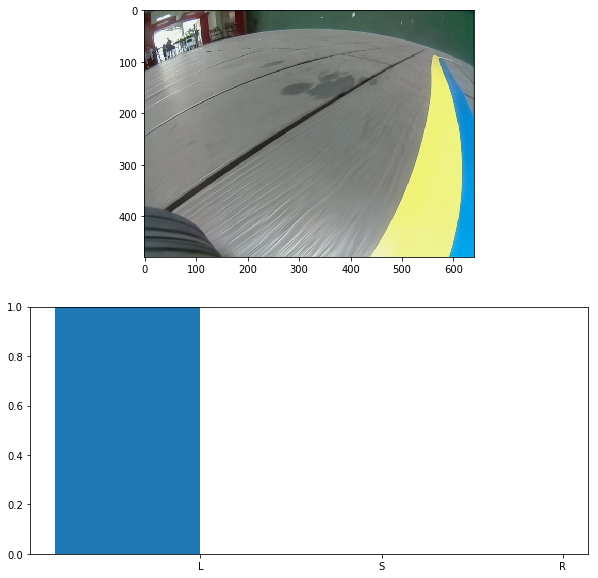

In [14]:
accuracy = pred(output, dataList, 1)

### 4-7. Save data list, prediction result, and accuracy 

In [15]:
if not os.path.isdir('testing-results'):
    os.makedirs('testing-results')
    print 'creat testing-results folder'
else:
    print 'testing-results folder exists'

import pickle

result_folder = 'testing-results/'

if not os.path.isdir(result_folder):
    os.makedirs(result_folder)
    print 'creat ' + result_folder  + 'folder'
else:
    print result_folder + ' exists'

# with open(result_folder + '/output', 'wb') as fp:
#     pickle.dump(output, fp)
# with open(result_folder + '/dataList', 'wb') as fp:
#     pickle.dump(dataList, fp)
with open(result_folder + '/accuracy.txt', "w") as text_file:
    text_file.write("Accuracy: %s" % accuracy)

testing-results folder exists
testing-results/ exists
